<a href="https://colab.research.google.com/github/Thien-Nhan-28/Essay/blob/main/C%C3%A1c_m%C3%B4_h%C3%ACnh_truy%E1%BB%81n_th%E1%BB%91ng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Kết nối với Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Essay'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Essay


In [ ]:
pip install tensorflow==2.17.0


# 2. Import thư viện

In [ ]:
import os
import cv2
import numpy as np
import glob2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Keras and TensorFlow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input


# 3. Đọc dữ liệu và gán nhãn

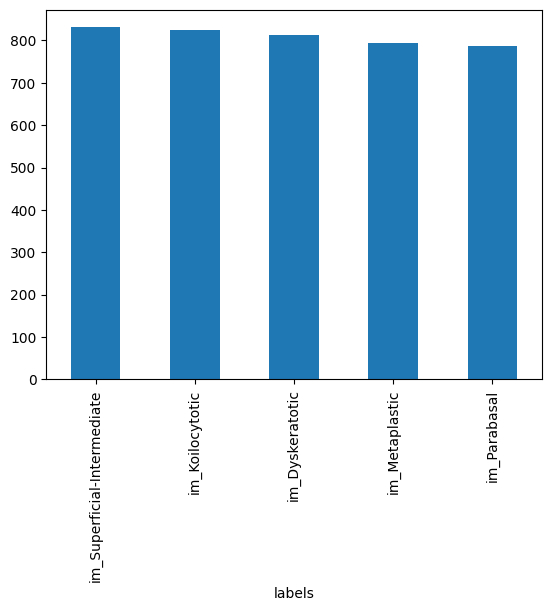

labels
im_Superficial-Intermediate    831
im_Koilocytotic                825
im_Dyskeratotic                813
im_Metaplastic                 793
im_Parabasal                   787
Name: count, dtype: int64


In [ ]:
# Danh sách các lớp
classes = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic",
           "im_Parabasal", "im_Superficial-Intermediate"]

labels = []
image_links = []
class_path = '/content/gdrive/MyDrive/Essay'

# Load tất cả ảnh và gán nhãn tương ứng
for class_name in classes:
    images = glob2.glob(f'{class_path}/{class_name}/{class_name}/CROPPED/*.bmp')
    labels.extend([class_name] * len(images))
    image_links.extend(images)

# Chuyển dữ liệu vào DataFrame để tiện xử lý
data = pd.DataFrame({'labels': labels, 'image_links': image_links})

# Kiểm tra số lượng ảnh trên mỗi lớp
data['labels'].value_counts().plot.bar()
plt.show()
print(data['labels'].value_counts())


# 4. Chia tập dữ liệu

In [ ]:
# Chia tập test trước (15%)
images_train_val, images_test, y_train_val, y_test = train_test_split(
    image_links, labels, stratify=labels, test_size=0.15, random_state=42
)

print(f'Train + Val: {len(images_train_val)}, Test: {len(images_test)}')
 # Chia tập train và validation từ tập train_val
images_train, images_val, y_train, y_val = train_test_split(
    images_train_val, y_train_val, stratify=y_train_val, test_size=0.176, random_state=42
)  # 0.176 * 85% = 15%

print(f'Train: {len(images_train)}, Val: {len(images_val)}, Test: {len(images_test)}')


Train + Val: 3441, Test: 608
Train: 2835, Val: 606, Test: 608


# 5. Chuẩn hóa hình ảnh

In [ ]:

def load_and_resize_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Đọc ảnh
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)  # Resize ảnh
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Đổi sang RGB (OpenCV đọc theo BGR)
    img_normalized = img_rgb / 255.0
    return img_normalized

# Kiểm tra và đảm bảo rằng tất cả ảnh đều đúng kích thước
for img_path in image_links:
    img = load_and_resize_image(img_path)
    if img is not None:
        # In ra kích thước ảnh đã được xử lý
        print(f"Processed image shape for {img_path}: {img.shape}")
        if img.shape != (224, 224, 3):
            print(f"Unexpected shape for {img_path}: {img.shape}")


Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_01.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/112_08.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_13.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_01.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_05.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/113_04.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_07.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_04.bmp: (224, 224, 3)
Processed image shape fo

In [ ]:

# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Chuyển đổi nhãn thành số cho tập huấn luyện và validation
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Chuyển đổi nhãn sang dạng one-hot cho tập huấn luyện và validation
y_train_onehot = to_categorical(y_train_encoded, num_classes=5)
y_val_onehot = to_categorical(y_val_encoded, num_classes=5)

# Chuyển đổi nhãn thành số cho tập test
y_test_encoded = encoder.transform(y_test)


In [ ]:
train_df = pd.DataFrame({'image_links': images_train, 'labels': y_train_encoded})
val_df = pd.DataFrame({'image_links': images_val, 'labels': y_val_encoded})
test_df = pd.DataFrame({'image_links': images_test, 'labels': y_test_encoded})

In [ ]:
# Khởi tạo ImageDataGenerator cho tập huấn luyện với tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Khởi tạo ImageDataGenerator cho tập kiểm tra (không tăng cường)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Khởi tạo ImageDataGenerator cho tập test (không tăng cường)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)

Found 2835 validated image filenames.
Found 606 validated image filenames.
Found 608 validated image filenames.


In [ ]:
# Kiểm tra kích thước của một vài ảnh trong tập huấn luyện
for i in range(5):
    img = load_and_resize_image(images_train[i])
    if img is not None:
        print(f"Image {i} shape: {img.shape}")

# Lấy một batch từ train_generator và kiểm tra kích thước
batch_images, batch_labels = next(train_generator)
print(f'Batch image shape: {batch_images.shape}')
print(f'Batch label shape: {batch_labels.shape}')


Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32,)


# 6. Trích xuất đặc trưng bằng ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# 7. Hàm trích xuất đặc trưng
def extract_features(generator, num_samples):
    features = np.zeros((num_samples, 2048))
    labels = []

    current_idx = 0

    for i, (batch_imgs, batch_labels) in enumerate(generator):
        print(f"Batch {i} - batch_imgs shape: {batch_imgs.shape}, batch_labels shape: {batch_labels.shape}")

        batch_features = model.predict(batch_imgs)
        batch_size = batch_features.shape[0]

        # Đảm bảo không vượt quá giới hạn của num_samples
        if current_idx + batch_size > num_samples:
            batch_size = num_samples - current_idx

        # Gán các đặc trưng và nhãn vào mảng chính
        features[current_idx:current_idx + batch_size] = batch_features[:batch_size]
        labels.extend(batch_labels[:batch_size])

        current_idx += batch_size  # Cập nhật chỉ số hiện tại

        if current_idx >= num_samples:
            break

    return features[:num_samples], np.array(labels[:num_samples])



# 8. Trích xuất đặc trưng cho train, val, test
X_train, y_train = extract_features(train_generator, len(train_df))
X_val, y_val = extract_features(val_generator, len(val_df))
X_test, y_test = extract_features(test_generator, len(test_df))


Batch 0 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Batch 1 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Batch 2 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Batch 3 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Batch 4 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 5 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Batch 6 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
Batch 7 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Batch 8 - batch_imgs shape: (32, 224, 224, 3), batch_labels shape: (32,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Batch 9 - batch_img

# 7. Huấn luyện mô hình

In [ ]:
# Khởi tạo các mô hình
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='linear', probability=True)  # SVM với kernel tuyến tính
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Huấn luyện từng mô hình
print("Training KNN...")
knn.fit(X_train, y_train)

print("Training SVM...")
svm.fit(X_train, y_train)

print("Training Random Forest...")
rf.fit(X_train, y_train)


Training KNN...
Training SVM...
Training Random Forest...


RandomForestClassifier(random_state=42)

# 8. Đánh giá và lưu mô hình

=== KNN ===
Accuracy: 0.9276315789473685
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.99      0.95       122
           1       0.98      0.77      0.86       124
           2       0.87      0.92      0.90       119
           3       0.91      0.97      0.94       118
           4       0.98      0.98      0.98       125

    accuracy                           0.93       608
   macro avg       0.93      0.93      0.93       608
weighted avg       0.93      0.93      0.93       608

Precision for KNN: 0.93
Recall for KNN: 0.93
F1-Score for KNN: 0.93


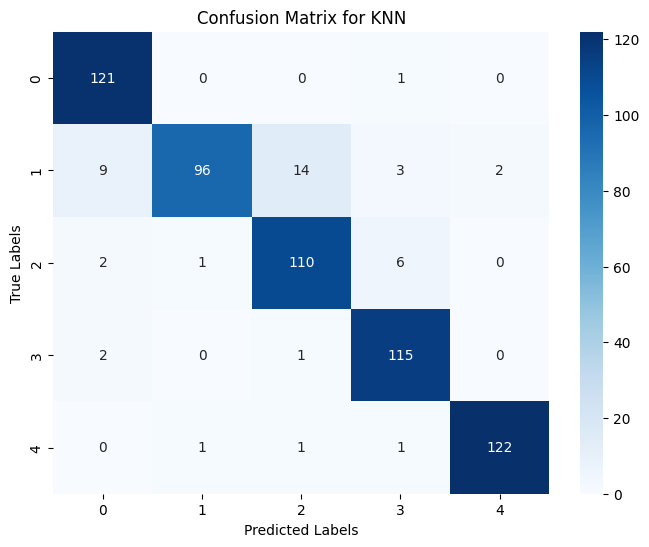

=== SVM ===
Accuracy: 0.9407894736842105
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       122
           1       0.88      0.91      0.89       124
           2       0.93      0.90      0.91       119
           3       0.99      0.96      0.97       118
           4       0.96      0.98      0.97       125

    accuracy                           0.94       608
   macro avg       0.94      0.94      0.94       608
weighted avg       0.94      0.94      0.94       608

Precision for SVM: 0.94
Recall for SVM: 0.94
F1-Score for SVM: 0.94


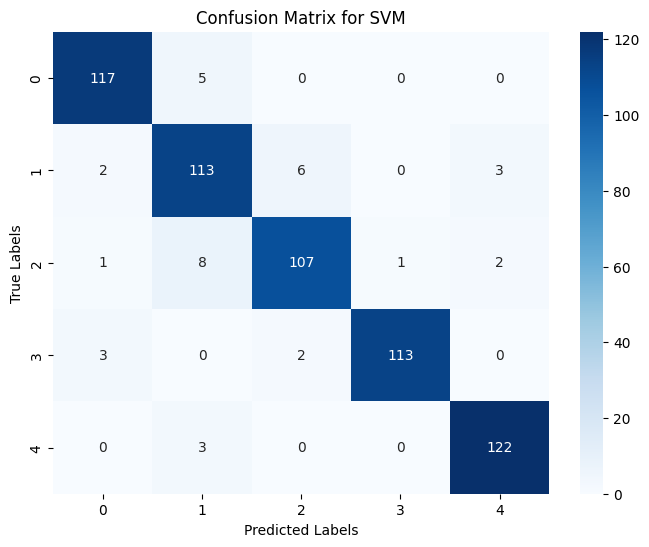

=== Random Forest ===
Accuracy: 0.9325657894736842
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       122
           1       0.95      0.84      0.89       124
           2       0.92      0.92      0.92       119
           3       0.96      0.92      0.94       118
           4       0.96      1.00      0.98       125

    accuracy                           0.93       608
   macro avg       0.93      0.93      0.93       608
weighted avg       0.93      0.93      0.93       608

Precision for Random Forest: 0.93
Recall for Random Forest: 0.93
F1-Score for Random Forest: 0.93


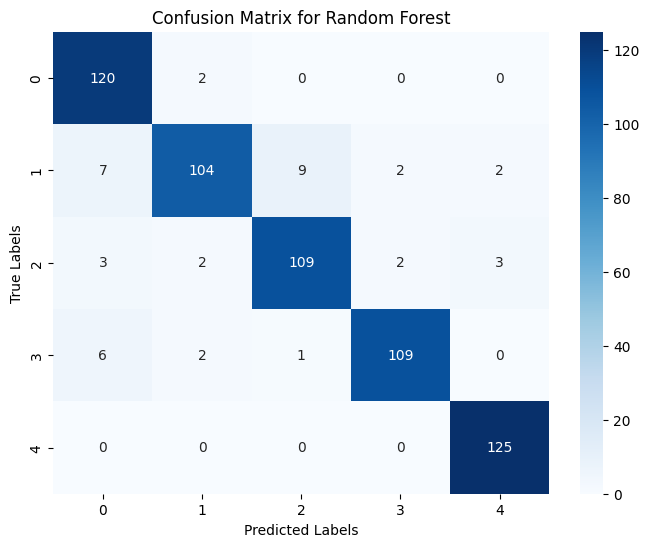


=== Summary of Results ===
KNN -> Precision: 0.93, Recall: 0.93, F1-Score: 0.93
SVM -> Precision: 0.94, Recall: 0.94, F1-Score: 0.94
Random Forest -> Precision: 0.93, Recall: 0.93, F1-Score: 0.93


In [ ]:
# Hàm để vẽ và lưu confusion matrix
def plot_confusion_matrix(y_test, y_pred, model_name, save_path="."):
    # Tính toán ma trận nhầm lẫn
    cm = confusion_matrix(y_test, y_pred)

    # Tạo thư mục lưu trữ nếu chưa tồn tại
    os.makedirs(save_path, exist_ok=True)

    # Vẽ ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y_test),
                yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")

    # Lưu ảnh vào file
    save_file_path = os.path.join(save_path, f"{model_name}_Confusion_Matrix.png")
    plt.savefig(save_file_path, dpi=300)
    plt.show()
    plt.close()  # Đóng biểu đồ sau khi lưu

# Hàm chung để in kết quả đánh giá
def evaluate_model(model_name, y_test, y_pred):
    print(f"=== {model_name} ===")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Trích xuất các chỉ số từ classification_report
    report = classification_report(y_test, y_pred, output_dict=True)
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]

    print(f"Precision for {model_name}: {precision:.2f}")
    print(f"Recall for {model_name}: {recall:.2f}")
    print(f"F1-Score for {model_name}: {f1_score:.2f}")
    return precision, recall, f1_score

# Đánh giá và vẽ confusion matrix cho từng mô hình
results = {}

# KNN
y_pred_knn = knn.predict(X_test)
results["KNN"] = evaluate_model("KNN", y_test, y_pred_knn)
plot_confusion_matrix(y_test, y_pred_knn, "KNN", save_path="confusion_matrices")

# SVM
y_pred_svm = svm.predict(X_test)
results["SVM"] = evaluate_model("SVM", y_test, y_pred_svm)
plot_confusion_matrix(y_test, y_pred_svm, "SVM", save_path="confusion_matrices")

# Random Forest
y_pred_rf = rf.predict(X_test)
results["Random Forest"] = evaluate_model("Random Forest", y_test, y_pred_rf)
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest", save_path="confusion_matrices")

# In tổng hợp kết quả
print("\n=== Summary of Results ===")
for model, metrics in results.items():
    print(f"{model} -> Precision: {metrics[0]:.2f}, Recall: {metrics[1]:.2f}, F1-Score: {metrics[2]:.2f}")


In [ ]:
results = {
    "Model": ["KNN", "SVM", "Random Forest"],
    "Accuracy": [
        accuracy_score(y_test, knn.predict(X_test)),
        accuracy_score(y_test, svm.predict(X_test)),
        accuracy_score(y_test, rf.predict(X_test)),
    ]
}

df_results = pd.DataFrame(results)
print(df_results)


           Model  Accuracy
0            KNN  0.927632
1            SVM  0.940789
2  Random Forest  0.932566


In [ ]:
# model.save('resnet50wsrkver.keras')  # Lưu theo định dạng native Keras


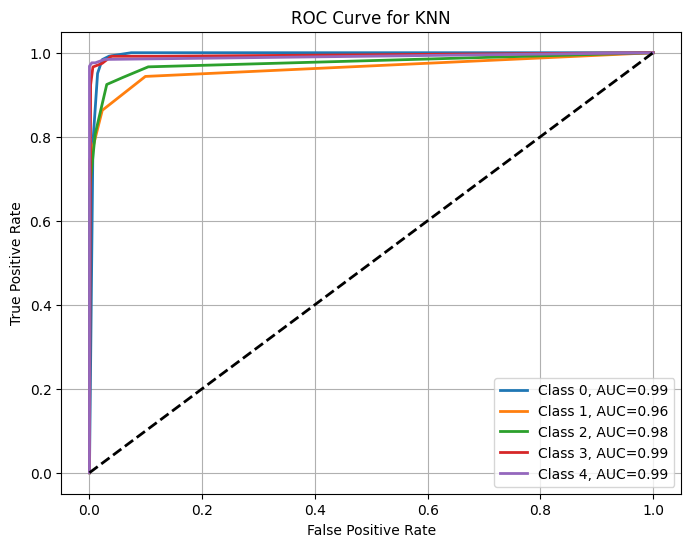

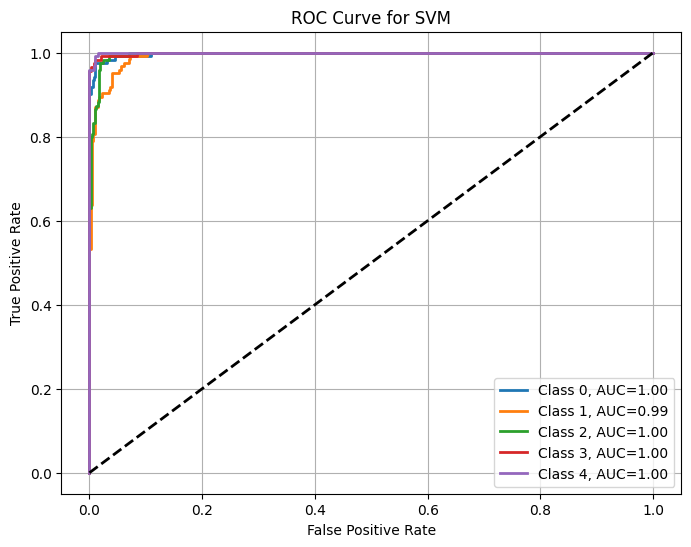

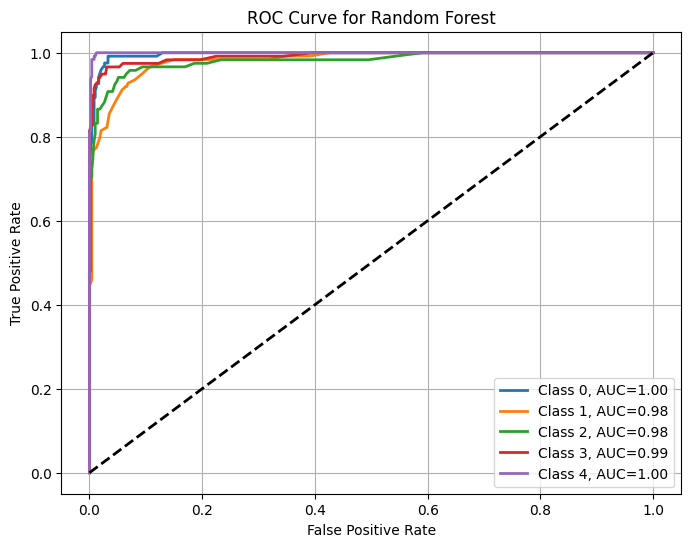

In [ ]:
# Chuyển nhãn thành dạng nhị phân nếu là bài toán đa lớp
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

# Tạo danh sách mô hình
models = [("KNN", knn), ("SVM", svm), ("Random Forest", rf)]

# Vẽ và lưu biểu đồ ROC cho từng mô hình
for model_name, model in models:
    plt.figure(figsize=(8, 6))

    # Dự đoán xác suất
    if hasattr(model, "predict_proba"):  # Với các mô hình hỗ trợ predict_proba
        y_score = model.predict_proba(X_test)
    else:  # Với SVM, cần dùng decision_function
        y_score = model.decision_function(X_test)

    # Tính ROC và AUC cho từng lớp
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"Class {i}, AUC={roc_auc:.2f}")

    # Vẽ đường chéo ngẫu nhiên
    plt.plot([0, 1], [0, 1], "k--", lw=2)

    # Định dạng biểu đồ
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve for {model_name}")
    plt.legend(loc="lower right")
    plt.grid()

    # Lưu biểu đồ vào tệp ảnh
    plt.savefig(f"{model_name}_ROC.png", dpi=300)  # Lưu với độ phân giải cao
    plt.show()
    plt.close()  # Đóng biểu đồ để tránh chồng lấp
